In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import word_tokenize
from wordcloud import WordCloud

import re
import json

from sklearn.feature_extraction.text import CountVectorizer
import string

In [2]:
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/uttkarsh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/uttkarsh/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /home/uttkarsh/nltk_data...


True

#1. Preprocessing

In [3]:
df = pd.read_csv("all_speeches.csv")

In [4]:
# get stopwords
stops = set(stopwords.words("english"))

In [5]:
df.head()

,reference,country,date,title,author,is_gov,text
0,r901128a_BOA,australia,1990-11-28,A Proper Role for Monetary Policy,fraser,0,They would no doubt argue that to have two obj...
1,r911003a_BOA,australia,1991-10-03,,fraser,0,Today I wish to talk about real interest rates...
2,r920314a_BOA,australia,1992-03-14,,fraser,0,I welcome this opportunity to talk about prosp...
3,r920529a_BOA,australia,1992-05-29,,fraser,0,It is a pleasure to have this opportunity to a...
4,r920817a_BOA,australia,1992-08-17,,fraser,0,"As a long-time fan of Don Sanders, I am deligh..."


In [6]:
print(df.shape)

(7721, 7)


In [7]:
with open('text_dictionary.json', 'r') as fp:
    corpus = json.load(fp)
corpus = list(corpus.values())

#convert corpus to df
corpus = pd.DataFrame(corpus, columns = ['text'])
corpus.head()

,text
0,International Monetary and Financial Committ...
1,Monetary Policy: An Outline*Respected Vice-Cha...
2,Investing in India: Challenges and Opportuniti...
3,Global Financial Turbulence and Financial Sec...
4,1 Fighting Inflation (Inaugural speech by Dr...


In [8]:
# clean corpus: remove punctuation 
corpus['text'] = corpus['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# remove single lettered words
corpus = corpus[corpus['text'].apply(lambda x: len(x) > 1)]

# remove numbers
corpus['text'] = corpus['text'].apply(lambda x: re.sub(r'\d+', '', x))

# remove 2 letter words
corpus['text'] = corpus['text'].apply(lambda x: re.sub(r'\b\w{1,2}\b', '', x))

# join all 'per' 'cent' words coming together
corpus['text'] = corpus['text'].apply(lambda x: re.sub(r'per cent', 'percent', x))


In [9]:
corpus.size

66

In [10]:
# visualize words with a wordcloud

# join all text
tokens = ' '.join(corpus['text'])


wordcloud = WordCloud(background_color="white", height=600, width=1000, stopwords=stops).generate(tokens)

#2. Visualizing the data

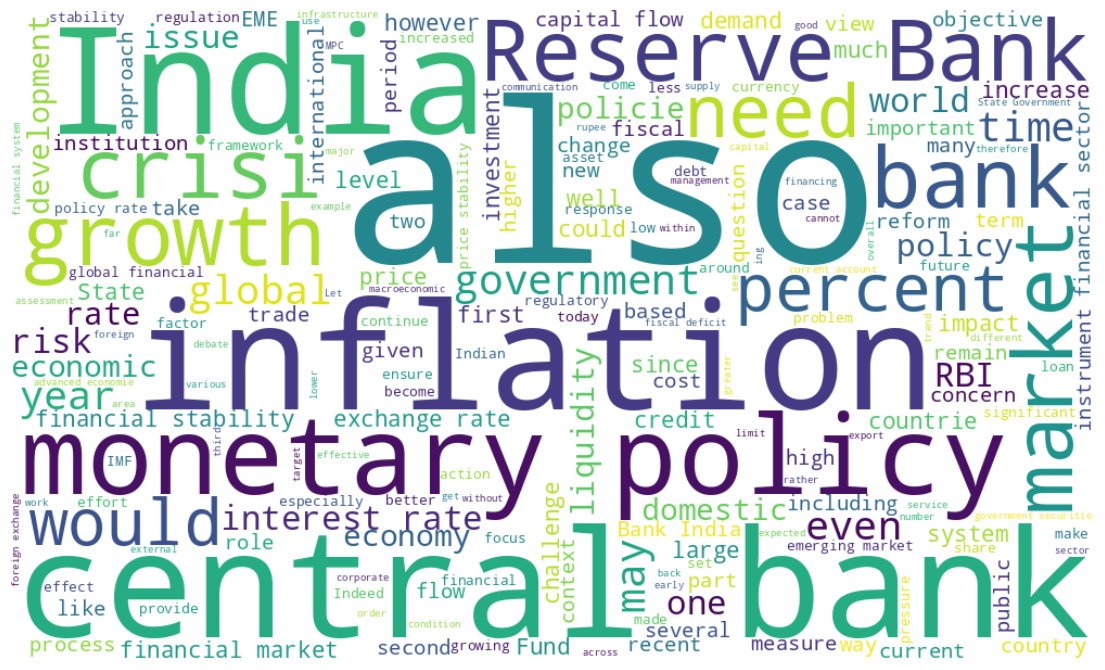

In [11]:
fig, ax = plt.subplots(figsize=(14,10))
ax.imshow(wordcloud, interpolation="bilinear")
ax.axis("off")
plt.show()

#3. Tokenizing the data

In [12]:
class Lemmatizer:
  def __init__(self):
    self.wnl = WordNetLemmatizer()

  def __call__(self, text):
    return [self.wnl.lemmatize(word) for word in word_tokenize(text)]

MAX_VOCAB_SIZE = 40000

vectorizer = CountVectorizer(tokenizer=Lemmatizer(), stop_words=list(stops), max_features=40000)
data = vectorizer.fit_transform(corpus['text'])


/home/uttkarsh/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/uttkarsh/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would'] not in stop_words.
  warnings.warn(


In [13]:
data

<66x16243 sparse matrix of type '<class 'numpy.int64'>'
	with 72830 stored elements in Compressed Sparse Row format>

In [120]:
print(f"Shape of data:", data.shape)

Shape of data: (66, 16243)


#4. Latent Dirichet Allocation

In [121]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(
    n_components=3,
    random_state=1234
)

In [122]:
# fit the lda on the corpus

lda.fit(data)

LatentDirichletAllocation(n_components=3, random_state=1234)

In [123]:
# plot top words of each topic 

def plot_top_words(model, feature_names, n_top_words=10):
  fig, axes = plt.subplots(1, 5, figsize=(30,15), sharex=True)
  axes = axes.flatten()

  for topic_idx, topic in enumerate (model.components_):
    top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
    top_features = [feature_names[i] for i in top_features_ind]
    weights = topic[top_features_ind]

    ax = axes[topic_idx]
    ax.barh(top_features, weights, height=0.7)
    ax.set_title(f"Topic {topic_idx + 1}", fontdict={"fontsize": 30})
    ax.invert_yaxis()
    ax.tick_params(axis="both", which="major", labelsize=20)
    for i in "top right left".split():
      ax.spines[i].set_visible(False)
    fig.suptitle("LDA", fontsize=40)

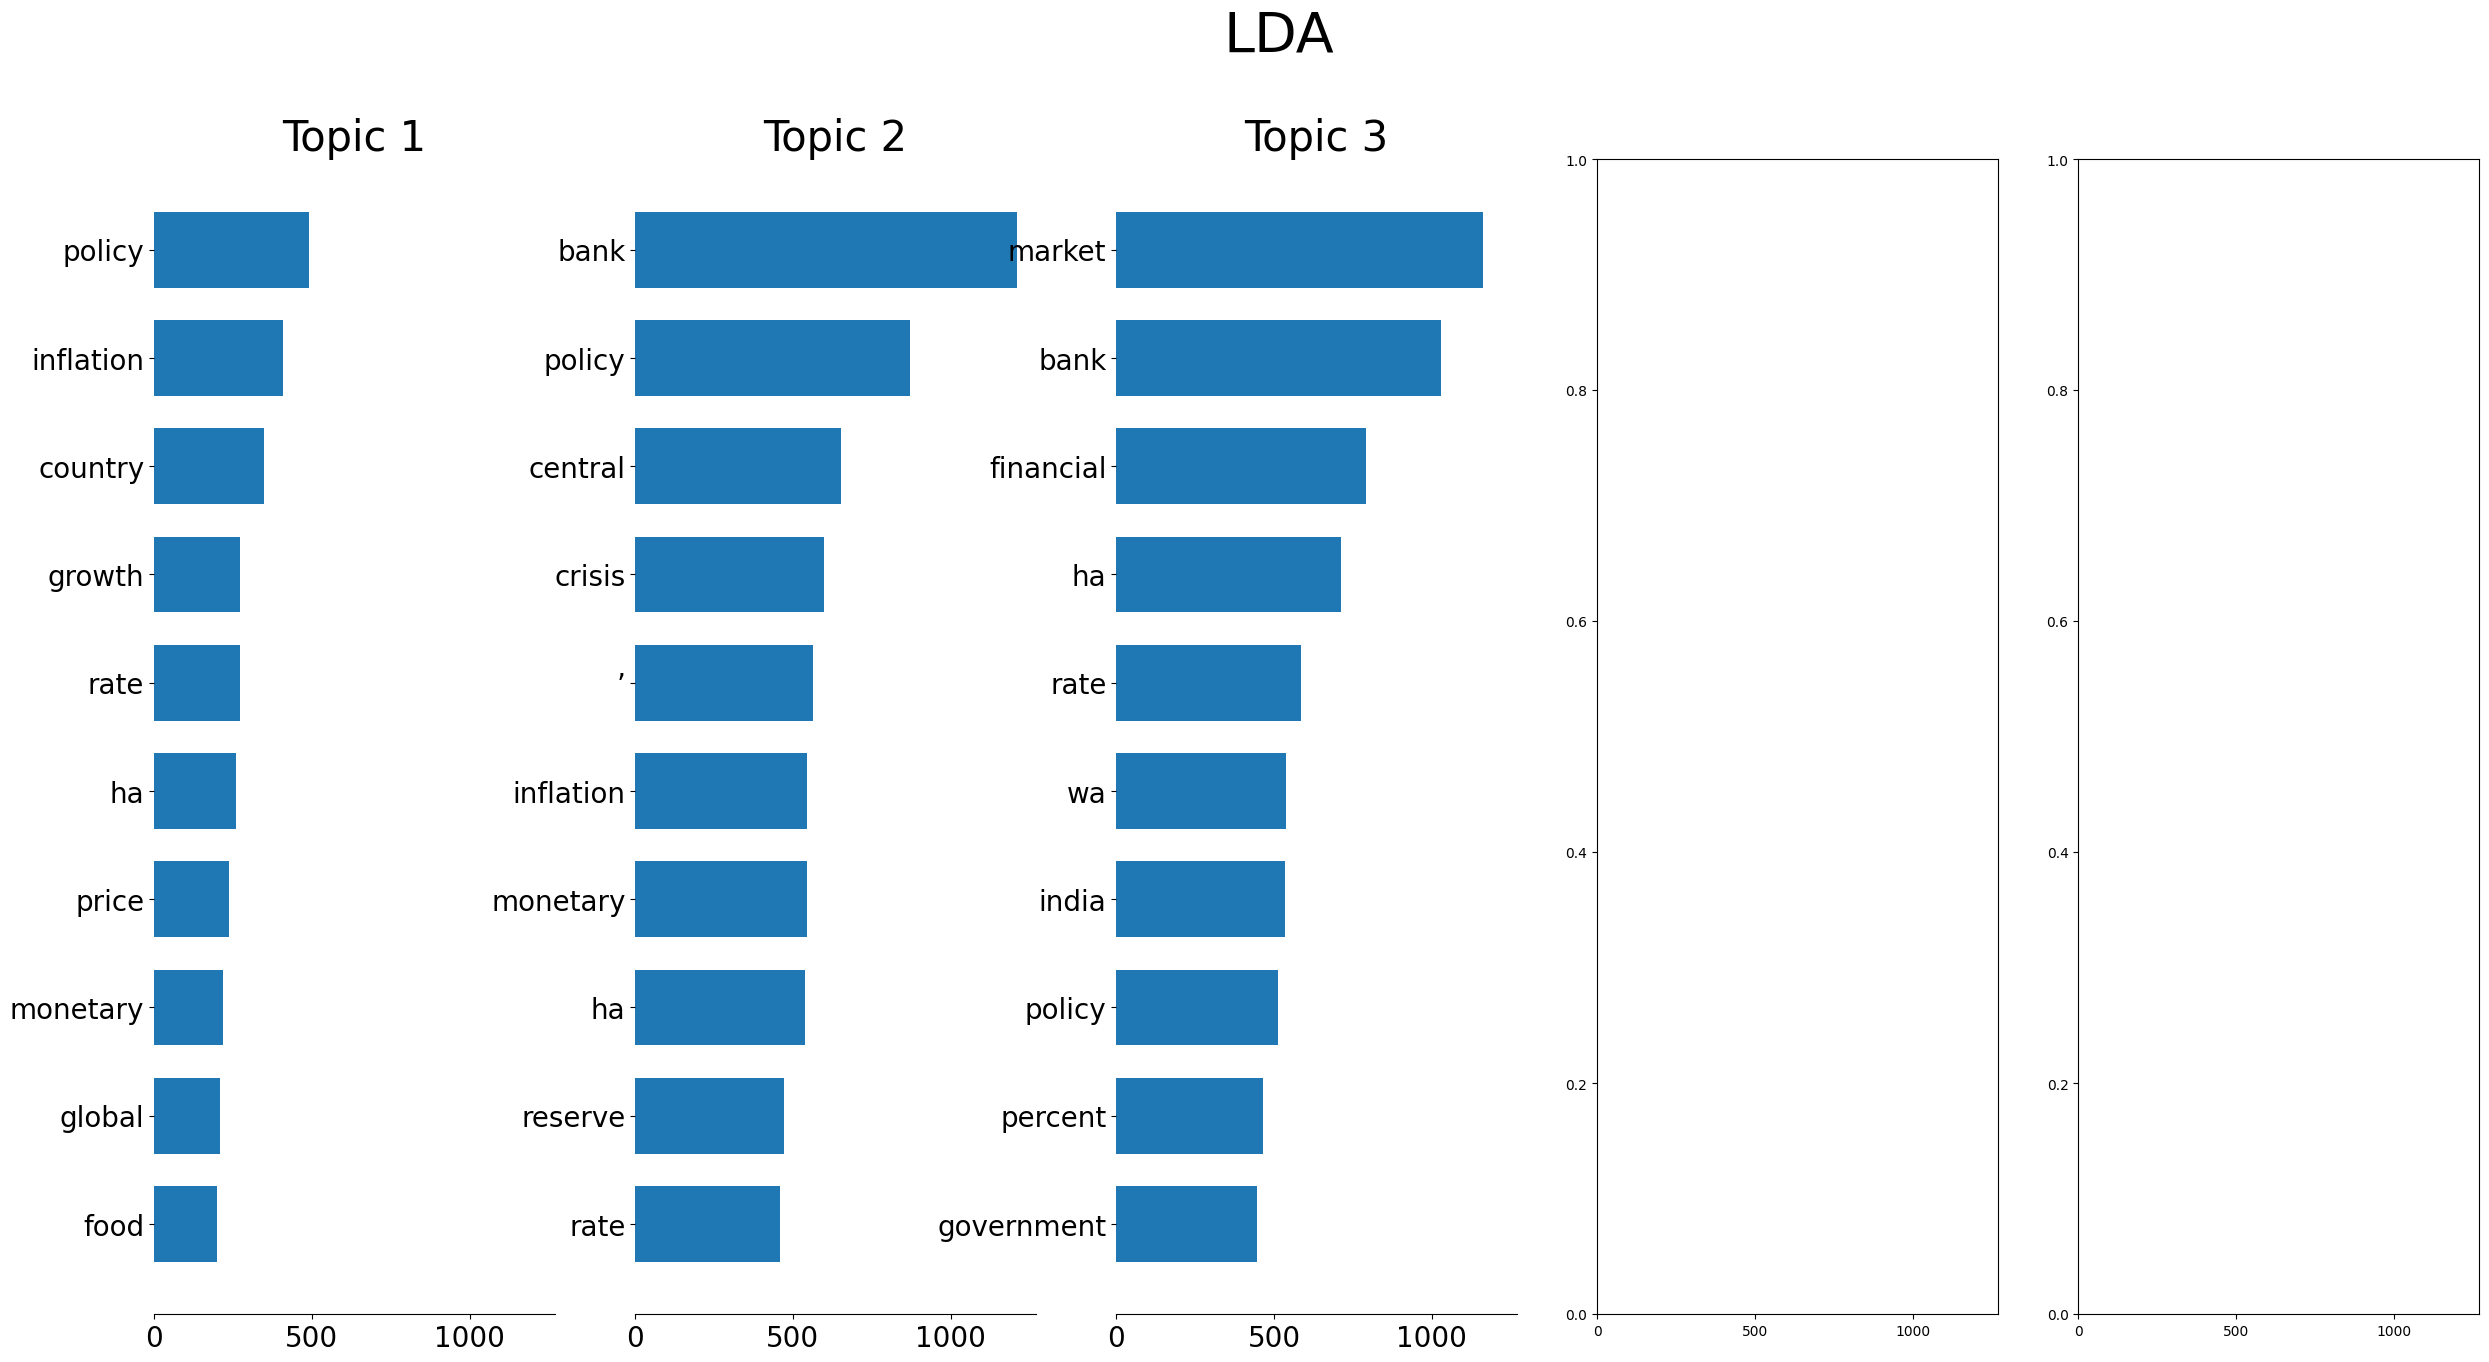

In [124]:
plot_top_words(lda, vectorizer.get_feature_names_out())

In [125]:
# get topic per document distribution
doc_topic = lda.transform(data)

# get the topic with the highest probability
topic_per_doc = np.argmax(doc_topic, axis=1)

#5. Postpreocessing and evaluation

In [126]:
# find suitable topic names
topic_names = [
    "Monetary policy and inflation",
    "Firms, competition and communities",
    "Banking market risks and ways to avoid them",
    "Central bank interest rates",
    "monetary policy and inflation in the eurozone"
]

In [127]:
# print random example

# size of sample
S = 10

inds = np.random.choice(len(corpus), S)

for i in inds:
  print("Topic:", topic_names[topic_per_doc[i]])
  print("____________________________________")
  print(corpus[i])
  print("\n")

Topic: Firms, competition and communities
____________________________________


KeyError: 43